<a href="https://www.kaggle.com/code/hongtptrai/big-data?scriptVersionId=289633332" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

**Library and Initial Enviroment**

In [1]:
import shutil
import subprocess
import os
import sys
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import cv2
import numpy as np
import glob
from torchvision.transforms import Compose
import random

print("=== PHASE 1: FINE-TUNING (FIX GRID ARTIFACTS) ===")

# --- 1. SETUP ENVIRONMENT ---
repo_dir = "/kaggle/working/Depth-Aware-Editing"
if not os.path.exists(repo_dir):
    subprocess.run(["git", "clone", "https://github.com/rishubhpar/Depth-Aware-Editing", repo_dir])

# Setup DINOv2
hub_dir = "/kaggle/working/torchhub"
dinov2_path = os.path.join(hub_dir, "facebookresearch_dinov2_main")
if not os.path.exists(dinov2_path):
    os.makedirs(hub_dir, exist_ok=True)
    subprocess.run(["wget", "-q", "-O", "dinov2.zip", "https://github.com/facebookresearch/dinov2/archive/refs/heads/main.zip"])
    subprocess.run(["unzip", "-q", "-o", "dinov2.zip", "-d", hub_dir])
    extracted_path = os.path.join(hub_dir, "dinov2-main")
    if os.path.exists(extracted_path):
        if os.path.exists(dinov2_path): shutil.rmtree(dinov2_path)
        os.rename(extracted_path, dinov2_path)
    if os.path.exists("dinov2.zip"): os.remove("dinov2.zip")

# Import Model
sys.path.append(os.path.join(repo_dir, "src", "Depth-Anything"))
try:
    from depth_anything.dpt import DepthAnything
    from depth_anything.util.transform import Resize, NormalizeImage, PrepareForNet
except ImportError:
    sys.path.append(os.path.join(repo_dir, "Depth-Anything"))
    from depth_anything.dpt import DepthAnything
    from depth_anything.util.transform import Resize, NormalizeImage, PrepareForNet

# --- 2. PREPARE DATASET (XỬ LÝ FOLDER LỒNG NHAU) ---
class NYUDataset(Dataset):
    def __init__(self, root_dir, limit=500): # Tăng limit lên chút để học được nhiều hơn
        self.root_dir = root_dir
        self.samples = [] 

        # Tìm file trong các subfolder (recursive=True xử lý vụ "kinh khủng" folder con)
        print(f">> Quét ảnh trong: {root_dir}")
        search_pattern = os.path.join(root_dir, "**", "*.jpg")
        all_jpgs = sorted(glob.glob(search_pattern, recursive=True))
        
        for jpg_path in all_jpgs:
            if len(self.samples) >= limit: break
            # NYU dataset thường có cặp: '1.jpg' và '1.png'
            png_path = jpg_path.replace(".jpg", ".png")
            if os.path.exists(png_path):
                self.samples.append((jpg_path, png_path))
        
        print(f"✅ Tìm thấy {len(self.samples)} cặp ảnh (JPG+PNG) trong các thư mục con.")

        self.transform = Compose([
            # Resize chuẩn input model
            Resize(width=518, height=518, resize_target=True, keep_aspect_ratio=True, ensure_multiple_of=14, resize_method='lower_bound', image_interpolation_method=cv2.INTER_CUBIC),
            NormalizeImage(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            PrepareForNet(),
        ])

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        c_path, d_path = self.samples[idx]
        
        img = cv2.imread(c_path)
        if img is None: img = np.zeros((518, 518, 3), dtype=np.uint8)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255.0
        
        # Load Depth
        depth = cv2.imread(d_path, cv2.IMREAD_UNCHANGED).astype(np.float32)
        
        # --- QUAN TRỌNG: CHUẨN HÓA DEPTH ---
        # NYU depth là mm, giá trị có thể lên tới 10000. 
        # Cần đưa về 0-1 để model không bị "ngáo" Loss 70
        if depth.max() > 0: 
            depth = depth / depth.max() 
            
        sample = self.transform({'image': img, 'depth': depth})
        return sample['image'], torch.from_numpy(sample['depth']).unsqueeze(0)

# --- 3. TRAINING LOOP ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Download Weights
orig_weights_path = "/kaggle/working/depth_anything_vits14.pth"
url = "https://huggingface.co/spaces/LiheYoung/Depth-Anything/resolve/main/checkpoints/depth_anything_vits14.pth"
if not os.path.exists(orig_weights_path):
    subprocess.run(["curl", "-L", "-o", orig_weights_path, url])

# Load Model
config = { "encoder": "vits", "features": 64, "out_channels": [48, 96, 192, 384], "use_bn": False, "use_clstoken": False }
model = DepthAnything(config).to(device)
if os.path.exists(orig_weights_path):
    model.load_state_dict(torch.load(orig_weights_path, map_location=device), strict=False)

train_dir = "/kaggle/input/nyu-depth-v2/nyu_data/data/nyu2_train"
dataset = NYUDataset(train_dir, limit=200)

if len(dataset) > 0:
    dataloader = DataLoader(dataset, batch_size=4, shuffle=True)
    # Giảm Learning Rate xuống thấp hơn nữa để tránh phá hỏng pre-trained weights
    optimizer = optim.AdamW(model.parameters(), lr=5e-6) 
    criterion = nn.MSELoss()

    print(">> Start Training...")
    model.train()
    for batch_idx, (imgs, depths) in enumerate(dataloader):
        imgs, depths = imgs.to(device), depths.to(device)
        
        preds = model(imgs)
        # Dùng BICUBIC thay vì Bilinear để mịn hơn ngay từ lúc train
        preds = torch.nn.functional.interpolate(preds.unsqueeze(1), size=depths.shape[-2:], mode='bicubic', align_corners=False)
        
        loss = criterion(preds, depths)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch_idx % 10 == 0:
            print(f"   Batch {batch_idx}/{len(dataloader)} | Loss: {loss.item():.4f}")
else:
    print("⚠️ No data found.")

# Save
output_model_dir = "/kaggle/working/model_checkpoints"
os.makedirs(output_model_dir, exist_ok=True)
finetuned_path = os.path.join(output_model_dir, "depth_anything_finetuned.pth")
torch.save(model.state_dict(), finetuned_path)
print(f"✅ Phase 1 Done. Saved: {finetuned_path}")

=== PHASE 1: FINE-TUNING (FIX GRID ARTIFACTS) ===


Cloning into '/kaggle/working/Depth-Aware-Editing'...
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1333  100  1333    0     0   6789      0 --:--:-- --:--:-- --:--:--  6801
100 94.6M  100 94.6M    0     0  58.8M      0  0:00:01  0:00:01 --:--:-- 81.7M
/kaggle/working/torchhub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/kaggle/working/torchhub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/kaggle/working/torchhub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


>> Quét ảnh trong: /kaggle/input/nyu-depth-v2/nyu_data/data/nyu2_train
✅ Tìm thấy 200 cặp ảnh (JPG+PNG) trong các thư mục con.
>> Start Training...
   Batch 0/50 | Loss: 62.0218
   Batch 10/50 | Loss: 0.1831
   Batch 20/50 | Loss: 0.1551
   Batch 30/50 | Loss: 0.0691
   Batch 40/50 | Loss: 0.0705
✅ Phase 1 Done. Saved: /kaggle/working/model_checkpoints/depth_anything_finetuned.pth


In [2]:
!rm -rf /kaggle/working/depth_output
!mkdir -p /kaggle/working/depth_output

CONFIG = {
    "REPO_PATH": "/kaggle/working/Depth-Aware-Editing/src/Depth-Anything",
    
    "INPUT_DATA_PATH": "/kaggle/input/nyu-depth-v2/nyu_data/data/nyu2_train/*", 
    
    "OUTPUT_DATA_PATH": "/kaggle/working/depth_output",
}

if not os.path.exists(CONFIG["OUTPUT_DATA_PATH"]):
    os.makedirs(CONFIG["OUTPUT_DATA_PATH"])

**Core Logic**

In [3]:
def reduce_process_partition(iterator):
    import warnings
    warnings.filterwarnings("ignore") # Tắt sạch log rác
    
    import os
    import sys
    import torch
    import torch.nn.functional as F
    import numpy as np
    import cv2 # Dùng OpenCV để resize đẹp hơn
    import time
    from PIL import Image
    from torchvision.transforms import Compose
    from pyspark import TaskContext
    
    repo_path = "/kaggle/working/Depth-Aware-Editing/src/Depth-Anything"
    if repo_path not in sys.path: sys.path.append(repo_path)
    
    try:
        from depth_anything.dpt import DepthAnything
        from depth_anything.util.transform import Resize, NormalizeImage, PrepareForNet
    except:
        sys.path.append("/kaggle/working/Depth-Aware-Editing/Depth-Anything")
        from depth_anything.dpt import DepthAnything
        from depth_anything.util.transform import Resize, NormalizeImage, PrepareForNet

    ctx = TaskContext.get()
    part_id = ctx.partitionId()
    
    if torch.cuda.is_available():
        gpu_id = part_id % torch.cuda.device_count()
        device = torch.device(f"cuda:{gpu_id}")
    else:
        device = torch.device("cpu")

    depth_model = None
    config = { "encoder": "vits", "features": 64, "out_channels": [48, 96, 192, 384], "use_bn": False, "use_clstoken": False }
    
    for attempt in range(3):
        try:
            torch.cuda.empty_cache()
            model = DepthAnything(config)
            depth_model = model.to(device).eval()
            break 
        except Exception:
            time.sleep(1)
            continue

    if depth_model is None: return iter([(f"Error_{part_id}", "Model Fail")])

    ckpt = "/kaggle/working/depth_anything_vits14.pth"
    if os.path.exists(ckpt):
        depth_model.load_state_dict(torch.load(ckpt, map_location=device), strict=False)

    # Transform chuẩn
    transform = Compose([
        Resize(width=518, height=518, resize_target=False, keep_aspect_ratio=True, ensure_multiple_of=14, resize_method='lower_bound', image_interpolation_method=cv2.INTER_CUBIC),
        NormalizeImage(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        PrepareForNet(),
    ])
    
    out_dir = "/kaggle/working/depth_output"
    os.makedirs(out_dir, exist_ok=True)
    results = []
    
    BATCH_SIZE = 8
    batch_data, batch_paths, batch_shapes = [], [], []

    def flush_batch():
        if not batch_data: return
        try:
            tensor = torch.from_numpy(np.concatenate(batch_data, axis=0)).to(device)
            with torch.no_grad(): preds = depth_model(tensor)
            
            # Xử lý từng ảnh trong batch
            preds_np = preds.cpu().numpy() # (B, H_small, W_small)
            
            for i, d_small in enumerate(preds_np):
                h_orig, w_orig = batch_shapes[i]
                
                # --- FIX LỖI GRID (CA RÔ) TẠI ĐÂY ---
                # Thay vì dùng torch.interpolate (dễ bị ô vuông), dùng cv2.resize với CUBIC
                # Resize từ output nhỏ (vd 37x37) lên size gốc (h, w)
                d_resized = cv2.resize(d_small, (w_orig, h_orig), interpolation=cv2.INTER_CUBIC)
                
                # Chuẩn hóa về 0-255 để lưu ảnh
                d_min = d_resized.min()
                d_max = d_resized.max()
                
                if (d_max - d_min) > 1e-6:
                    d_norm = (d_resized - d_min) / (d_max - d_min) * 255.0
                else:
                    d_norm = np.zeros_like(d_resized)
                
                # Lưu file
                base_name = os.path.basename(batch_paths[i])
                clean_name = base_name.replace("_colors.png", "").replace(".png", "")
                fname = f"{clean_name}.png"
                
                Image.fromarray(d_norm.astype(np.uint8)).save(os.path.join(out_dir, fname))
                results.append((batch_paths[i], "Success"))
                
        except Exception as e:
            for p in batch_paths: results.append((p, str(e)))

    # Main Loop
    for key, raw_path in iterator: 
        try:
            file_path = raw_path.replace("file:", "")
            if not os.path.exists(file_path): continue
            
            img = Image.open(file_path).convert("RGB")
            np_img = np.array(img) / 255.0
            
            batch_shapes.append(np_img.shape[:2]) # Lưu size gốc
            batch_data.append(transform({'image': np_img})['image'][None])
            batch_paths.append(file_path)
            
            if len(batch_data) >= BATCH_SIZE:
                flush_batch()
                batch_data, batch_paths, batch_shapes = [], [], []
        except: 
            pass
        
    flush_batch()
    return iter(results)

**MapReduce**

In [4]:
def run_job():    
    import random
    from pyspark.sql import SparkSession
    from pyspark.sql.functions import col    
    try: SparkSession.getActiveSession().stop()
    except: pass

    # 2. CẤU HÌNH SPARK MẠNH HƠN ĐỂ TRÁNH TIMEOUT
    spark = SparkSession.builder \
        .master("local[2]") \
        .appName("Depth_Inference_Test_Set") \
        .config("spark.driver.memory", "4g") \
        .config("spark.executor.memory", "4g") \
        .config("spark.driver.maxResultSize", "2g") \
        .config("spark.network.timeout", "600s") \
        .config("spark.executor.heartbeatInterval", "60s") \
        .getOrCreate()
    
    # Tắt log INFO của Spark cho đỡ rối mắt
    spark.sparkContext.setLogLevel("ERROR")

    print(">> Reading Data from Test Set...")
    CONFIG_INPUT = "/kaggle/input/nyu-depth-v2/nyu_data/data/nyu2_test/*"
    
    df = spark.read.format("binaryFile") \
        .option("recursiveFileLookup", "true") \
        .load(CONFIG_INPUT) \
        .filter(col("path").like("%_colors.png")) \
        .select("path") 

    total_files = df.count()
    print(f">> FOUND: {total_files} images (RGB).")

    # Giảm số partition một chút để mỗi partition có việc làm ổn định hơn
    NUM_PARTITIONS = 20 
    print(f">> ⚡ PIPELINE START ({NUM_PARTITIONS} Partitions)")
    
    def map_assign_key(row):
        key = random.randint(0, NUM_PARTITIONS - 1)
        return (key, row.path)
        
    mapped_rdd = df.rdd.map(map_assign_key)
    partitioned_rdd = mapped_rdd.partitionBy(NUM_PARTITIONS)
    
    # Chạy Reduce
    try:
        count = partitioned_rdd.mapPartitions(reduce_process_partition).count()
        print(f">> ✅ DONE! Successfully processed: {count} images.")
    except Exception as e:
        print(">> ❌ JOB FAILED (Nhưng có thể một số ảnh đã được lưu).")
        print(e)
        
    spark.stop()

if __name__ == "__main__":
    run_job()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/01/02 08:18:52 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


>> Reading Data from Test Set...


>> FOUND: 654 images (RGB).
>> ⚡ PIPELINE START (20 Partitions)


>> ✅ DONE! Successfully processed: 654 images.


**Result**

=== VISUALIZATION RESULTS ===
✅ Found 5 output images. Displaying samples...


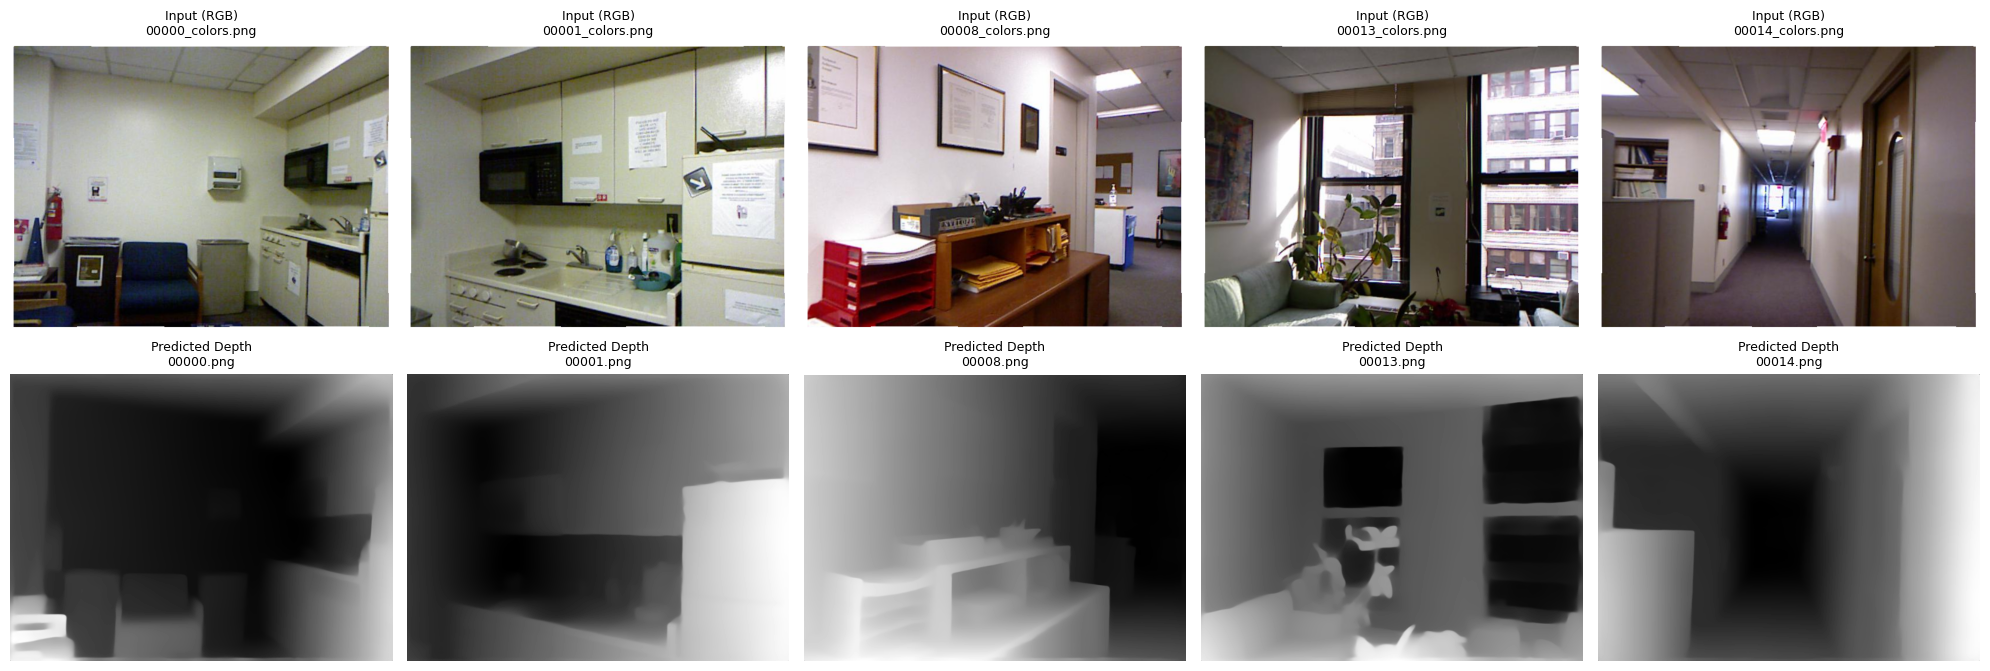

In [5]:
import matplotlib.pyplot as plt
import glob
from PIL import Image
import os

print("=== VISUALIZATION RESULTS ===")

output_dir = "/kaggle/working/depth_output"
# Path to the Test Dataset
input_dir = "/kaggle/input/nyu-depth-v2/nyu_data/data/nyu2_test"

output_paths = sorted(glob.glob(os.path.join(output_dir, "*.png")))[:5]

if not output_paths:
    print("❌ No output images found!")
else:
    print(f"✅ Found {len(output_paths)} output images. Displaying samples...")
    
    num_show = len(output_paths)
    fig, axes = plt.subplots(2, num_show, figsize=(4 * num_show, 7))
    if num_show == 1: axes = axes.reshape(2, 1)

    for i in range(num_show):
        out_path = output_paths[i]
        out_img = Image.open(out_path)
        
        # Mapping Logic:
        # Output: "00000.png"
        # Input: "00000_colors.png"
        basename = os.path.splitext(os.path.basename(out_path))[0] # "00000"
        input_filename = f"{basename}_colors.png"
        in_path = os.path.join(input_dir, input_filename)
        
        # ROW 1: Input Image
        if os.path.exists(in_path):
            in_img = Image.open(in_path)
            axes[0, i].imshow(in_img)
            axes[0, i].set_title(f"Input (RGB)\n{input_filename}", fontsize=9)
        else:
            axes[0, i].text(0.5, 0.5, "Not Found", ha='center')
            axes[0, i].set_title("Missing Input", fontsize=8, color='red')
        axes[0, i].axis('off')

        # ROW 2: Output Depth Map
        axes[1, i].imshow(out_img, cmap='gray') # Depth map is usually grayscale
        axes[1, i].set_title(f"Predicted Depth\n{os.path.basename(out_path)}", fontsize=9)
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()